# **Amazon Lookout for Equipment** - Getting started
*Part 3 - Model training*

## Initialization
---
This repository is structured as follow:

```sh
. lookout-equipment-demo
|
├── data/
|   ├── interim                          # Temporary intermediate data
|   ├── processed                        # Finalized datasets
|   └── raw                              # Immutable original data
|
├── getting_started/
|   ├── 1_data_preparation.ipynb
|   ├── 2_dataset_creation.ipynb
|   ├── 3_model_training.ipynb                 <<< THIS NOTEBOOK <<<
|   ├── 4_model_evaluation.ipynb
|   ├── 5_inference_scheduling.ipynb
|   ├── 6_visualization_with_quicksight.ipynb
|   └── 7_cleanup.ipynb
|
└── utils/
    └── lookout_equipment_utils.py
```

### Notebook configuration update

In [2]:
!pip install --quiet --upgrade sagemaker tqdm lookoutequipment

### Imports

In [3]:
import boto3
import config
import os
import pandas as pd
import sagemaker
import sys

# SDK / toolbox for managing Lookout for Equipment API calls:
import lookoutequipment as lookout

In [4]:
ROLE_ARN     = sagemaker.get_execution_role()
REGION_NAME  = boto3.session.Session().region_name
BUCKET       = config.BUCKET
PREFIX       = config.PREFIX_LABEL
DATASET_NAME = config.DATASET_NAME
MODEL_NAME   = config.MODEL_NAME

Based on the label time ranges, we will use the following time ranges:

* **Train set:** 1st January 2019 - 31st July 2019: Lookout for Equipment needs at least 90 days of training data and this period contains a few labelled ranges with some anomalies.
* **Evaluation set:** 1st August 2019 - 27th October 2019 *(this test set includes both normal and abnormal data to evaluate our model on)*

In [5]:
# Configuring time ranges:
training_start   = pd.to_datetime('2019-01-01 00:00:00')
training_end     = pd.to_datetime('2019-07-31 00:00:00')
evaluation_start = pd.to_datetime('2019-08-01 00:00:00')
evaluation_end   = pd.to_datetime('2019-10-27 00:00:00')

print(f'  Training period | from {training_start} to {training_end}')
print(f'Evaluation period | from {evaluation_start} to {evaluation_end}')

  Training period | from 2019-01-01 00:00:00 to 2019-07-31 00:00:00
Evaluation period | from 2019-08-01 00:00:00 to 2019-10-27 00:00:00


## Model training
---

In [6]:
# Prepare the model parameters:
lookout_model = lookout.LookoutEquipmentModel(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

# Set the training / evaluation split date:
lookout_model.set_time_periods(evaluation_start,
                               evaluation_end,
                               training_start,
                               training_end)

# Set the label data location:
lookout_model.set_label_data(bucket=BUCKET, 
                             prefix=PREFIX,
                             access_role_arn=ROLE_ARN)

Other optional configurations include:
* Setting a sensor to define conditions stating when the equipment / process is not running (off time conditions)
* Using only a subset of the sensors available in the dataset (if you don't provide this, Lookout for Equipment will use all the sensors available in your dataset)
* Requesting a resampling of the data (this accelerates the training but makes your data coarser, which may cut off some anomalies and precursor events of interest)

In [6]:
# If you have a signal to mark off time for your asset/process, you 
# can use the following line to mention it to Lookout for Equipment:

# lookout_model.set_off_conditions('centrifugal-pump\\Sensor13<4000')

# If you want to only use a subset of the ingested signals to train
# a model, you can do so with the following method. This function
# expects a Python dictionnary as an argument, where the keys are
# the name of the components and the values are lists of sensors
# to use from this component:

# lookout_model.set_subset_schema({
#     "centrifugal-pump": ['Timestamp', 'Sensor0', 'Sensor3']
# })

# This sets up the rate the service will resample the data before 
# training: we will keep the original sampling rate in this example
# (5 minutes), but feel free to use a larger sampling rate to accelerate 
# the training time:

# lookout_model.set_target_sampling_rate(sampling_rate='PT15M')

You can double check your model creation request like this:

In [7]:
lookout_model.create_model_request

{'ModelName': 'getting-started-pump-model',
 'DatasetName': 'getting-started-pump',
 'TrainingDataStartTime': datetime.datetime(2019, 1, 1, 0, 0),
 'TrainingDataEndTime': datetime.datetime(2019, 7, 31, 0, 0),
 'EvaluationDataStartTime': datetime.datetime(2019, 8, 1, 0, 0),
 'EvaluationDataEndTime': datetime.datetime(2019, 10, 27, 0, 0),
 'RoleArn': 'arn:aws:iam::038552646228:role/AmazonSageMaker-LookoutEquipmentEnv',
 'LabelsInputConfiguration': {'S3InputConfiguration': {'Bucket': 'lookout-equipment-poc',
   'Prefix': 'getting_started/label-data/'}}}

The following method encapsulates a call to the [**CreateModel**](https://docs.aws.amazon.com/lookout-for-equipment/latest/ug/API_CreateModel.html) API:

In [8]:
# Actually create the model and train it:
lookout_model.train()

{'ModelArn': 'arn:aws:lookoutequipment:eu-west-1:038552646228:model/getting-started-pump-model/07a0f7e9-0fb1-42e8-94d8-b4cd92778ebb',
 'Status': 'IN_PROGRESS',
 'ResponseMetadata': {'RequestId': '6709efe1-cf7f-4314-a533-559dd10620ee',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6709efe1-cf7f-4314-a533-559dd10620ee',
   'content-type': 'application/x-amz-json-1.0',
   'content-length': '155',
   'date': 'Fri, 13 May 2022 09:14:19 GMT'},
  'RetryAttempts': 0}}

A training is now in progress as captured by the console:
    
![Training in progress](assets/create-model-training-in-progress.png)

Use the following cell to capture the model training progress. **This model should take around 30-45 minutes to be trained.** Key drivers for training time usually are:
* **Number of labels** in the label dataset (if provided)
* Number of datapoints: this number depends on the **sampling rate**, the **number of time series** and the **time range**.

The following method encapsulate a call to the [**DescribeModel**](https://docs.aws.amazon.com/lookout-for-equipment/latest/ug/API_DescribeModel.html) API and collect the model progress by looking at the `Status` field retrieved from this call:
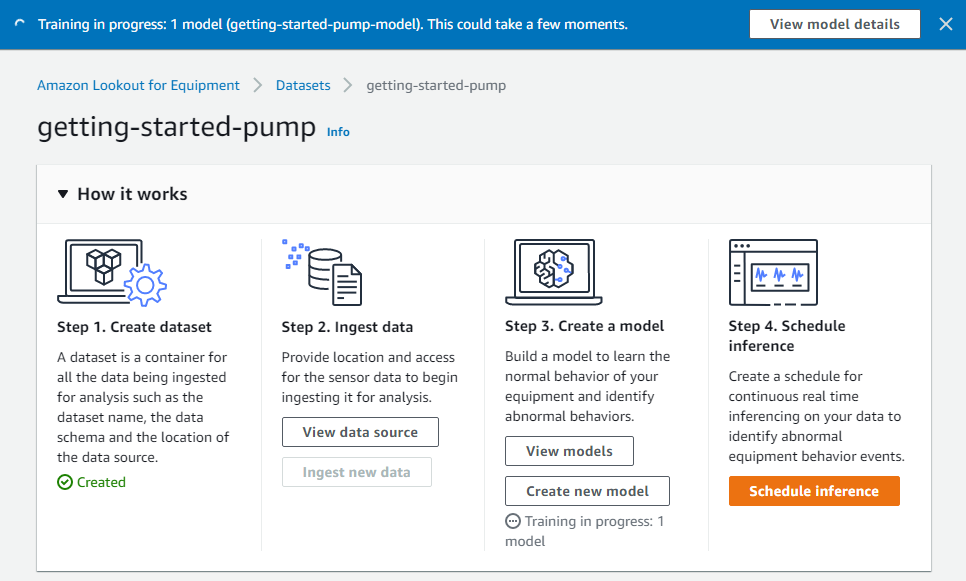

In [9]:
lookout_model.poll_model_training(sleep_time=300)

2022-05-13 09:21:05 | Model training: IN_PROGRESS
2022-05-13 09:26:06 | Model training: IN_PROGRESS
2022-05-13 09:31:06 | Model training: IN_PROGRESS
2022-05-13 09:36:06 | Model training: IN_PROGRESS
2022-05-13 09:41:06 | Model training: SUCCESS


A model is now trained and we can visualize the results of the back testing on the evaluation window selected at the beginning on this notebook:

![Training complete](assets/model-performance.png)

In the console, **you can click on each detected event**: Amazon Lookout for Equipment unpacks the ranking and display the top sensors contributing to the detected events.

When you open this window, the first event is already selected and this is the detailed view you will get from the console:

![Event details](assets/model-diagnostics.png)

This dataset contains 30 sensors:
* If each sensor contributed the same way to this event, every sensors would **equally contribute** to this event (said otherwise, every sensor would have a similar feature importance of `100% / 30 = 3.33%`).
* The top sensors (e.g. **Sensor2** with a **7.65% importance**) have a contribution that is significantly higher than this threshold, which seems statistically relevant.
* If the model continues outputing detected anomalies with a similar ranking, this might push a maintenance operator to go and have a look at the associated components.

## Conclusion
---

In this notebook, we use the dataset created in part 2 of this notebook series and trained an Amazon Lookout for Equipment model.

From here you can either head:
* To the next notebook where we will **extract the evaluation data** for this model and use it to perform further analysis on the model results: this is optional and just gives you some pointers on how to post-process and visualize the data provided by Amazon Lookout for Equipment.
* Or to the **inference scheduling notebook** where we will start the model, feed it some new data and catch the results.